# Data & AI: Swarm IOT

## Don't forget to read the [README](README.md)!

In [1]:
#imports
import pandas as pd
import cv2  as cv
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
import tensorflow as tf
import time 


## Inlezen van csv

In [2]:
#read the csv named complete_swarmIoT_full_labeled_dataset.csv and save it in a dataframe
df = pd.read_csv('complete_swarmIoT_full_labeled_dataset.csv')
df['image'].head()


0    1666698189853.jpg
1    1666698196832.jpg
2    1666698203856.jpg
3    1666698210837.jpg
4    1666698217850.jpg
Name: image, dtype: object

## Inlezen van alle fotos

in de les hebben we dit gezien
er zijn corrupte fotos. Maar dit kan aan mij liggen ik heb 4 keer de zip moeten downloaden omdat de download telkens failde. Er zijn bij mij 4 corrupte fotos.

```python

leuven = plt.imread('data/leuven.jpg')
proximus = plt.imread('data/proximus.jfif')

leuven = cv.resize(leuven, (416, 416))
proximus = cv.resize(proximus, (416, 416))
images = [leuven, proximus]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
ax[0].imshow(leuven)
ax[1].imshow(proximus)

```

In [3]:
path = 'data computer vision assignment\\'
extension = '*jpg'

images = []
imagesNames = []

for root, dirs, files in os.walk(path):
    for file in glob.glob(os.path.join(root, extension)):
        try:
            image = plt.imread(file)
            image = cv.resize(image, (416, 416))
            images.append(image)
            imagesNames.append(file.split('\\')[-1])

        except:
            print('image corrupted')
            print(file)

image corrupted
data computer vision assignment\3 De nayer (Loop piste)\1666699912159.jpg
image corrupted
data computer vision assignment\3 De nayer (Loop piste)\1666699919158.jpg
image corrupted
data computer vision assignment\3 De nayer (Loop piste)\1666699926156.jpg
image corrupted
data computer vision assignment\3 De nayer (Loop piste)\1666699933158.jpg


In [4]:
images

[array([[[ 36,  39,  48],
         [ 44,  47,  54],
         [ 55,  57,  64],
         ...,
         [ 71,  67,  32],
         [ 80,  77,  46],
         [ 76,  75,  47]],
 
        [[ 39,  42,  51],
         [ 44,  46,  54],
         [ 51,  52,  60],
         ...,
         [ 79,  74,  40],
         [ 78,  75,  45],
         [ 81,  78,  51]],
 
        [[ 41,  43,  52],
         [ 44,  44,  52],
         [ 50,  50,  58],
         ...,
         [101,  96,  63],
         [ 99,  94,  65],
         [100,  95,  70]],
 
        ...,
 
        [[121, 111, 120],
         [121, 111, 120],
         [116, 106, 115],
         ...,
         [176, 164, 165],
         [177, 165, 167],
         [180, 168, 170]],
 
        [[132, 122, 131],
         [133, 123, 132],
         [131, 121, 130],
         ...,
         [188, 176, 178],
         [182, 170, 172],
         [175, 163, 165]],
 
        [[136, 126, 135],
         [137, 127, 136],
         [138, 128, 137],
         ...,
         [188, 176, 178],
  

In [5]:
images2 = []

# if the image in images is in df['image'] then append it to images2
for image in df['image']:
    if image in imagesNames:
        images2.append(images[imagesNames.index(image)])
len(images2[0])

416

## Easy task

### Using an existing object detection model from YOLO

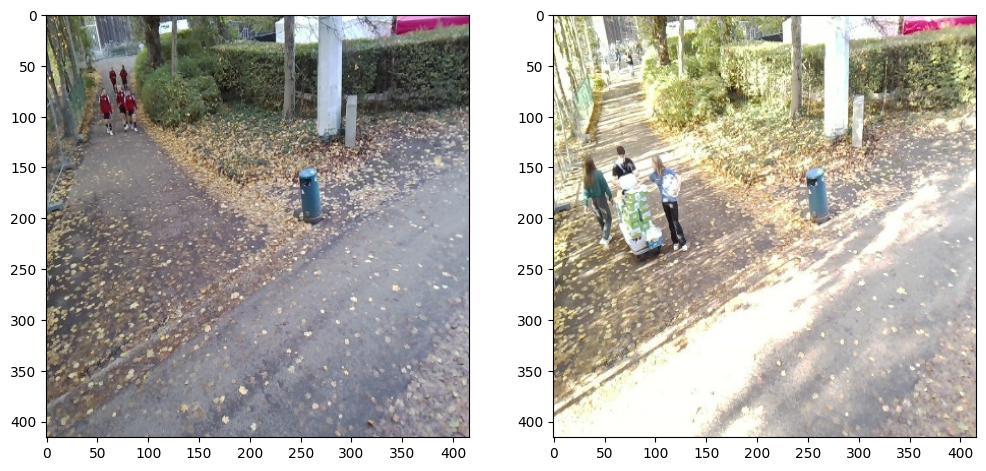

In [6]:
classes = open('coco.names').read().strip().split('\n')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
ax[0].imshow(images[6700])
ax[1].imshow(images[6505])

In [7]:
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8') # Colors for our classes
net = cv.dnn.readNetFromDarknet('YOLO/yolov3.cfg', 'YOLO/yolov3.weights')
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)

In [8]:
blob = cv.dnn.blobFromImage(images[6505], 1/255.0, (416, 416), crop=False)
blob.shape

(1, 3, 416, 416)

In [9]:
ln = net.getLayerNames()
outNames = net.getUnconnectedOutLayersNames()


net.setInput(blob)
t0 = time.time()
outputs = net.forward(outNames)
t = time.time()
t - 10

1674388413.5611885

In [10]:
outputs = np.vstack(outputs)

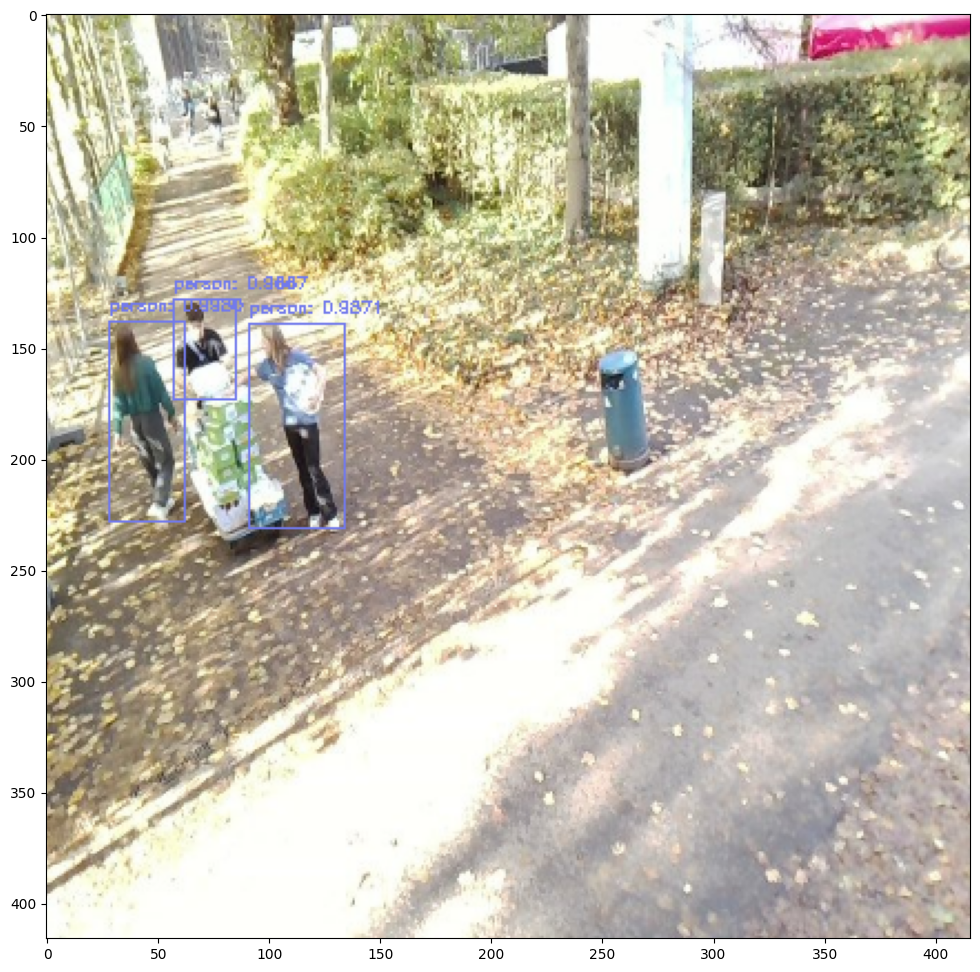

In [11]:
proximus = images[6505].copy()
boxes = []
confidences = []
classIDs = []
confTreshHold = 0.5
h, w = proximus.shape[:2]


for output in outputs:
        scores = output[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        if confidence > confTreshHold:
            box = output[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            box = [x, y, int(width), int(height)]
            boxes.append(box)
            confidences.append(float(confidence))
            classIDs.append(classID)

indices = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
if len(indices) > 0:
    for i in indices.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        color = [int(c) for c in colors[classIDs[i]]]
        cv.rectangle(proximus, (x, y), (x + w, y + h), color, 1)
        text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
        cv.putText(proximus, text, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.25, color, 1)


fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(proximus)

## Medium task

### Detailed comparison of fine-tuning versus from scratch (performance)

#### Fine-tuning

In [12]:
img_height = 416
img_width = 416
batch_size = 512

In [13]:
base_model = tf.keras.applications.Xception(weights="imagenet", include_top=False, input_shape=(img_height,img_width,3), pooling="max")

base_model.trainable = False

fine_tuning = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1),
    base_model,
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [14]:
fine_tuning.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

fine_tuning.build(input_shape=(batch_size, img_height, img_width, 3))

fine_tuning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (512, 416, 416, 3)        0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (512, 128)                262272    
                                                                 
 dense_1 (Dense)             (512, 32)                 4128      
                                                                 
 dense_2 (Dense)             (512, 5)                  165       
                                                                 
Total params: 21,128,045
Trainable params: 266,565
Non-trainable params: 20,861,480
_________________________________________________________________


In [15]:
np_df = np.array(images2)


In [16]:
#check if there are nan values in the array
df['choice'].sort_values()

3365    0
1225    0
1224    0
1223    0
3961    0
       ..
5301    2
5300    2
5299    2
1014    2
0       2
Name: choice, Length: 6833, dtype: int64

In [17]:
fine_tuning.fit(
    x = np_df,
    y = df['choice'],
    epochs=2,
)

Epoch 1/2
214/214 [==============================] - 899s 4s/step - loss: 0.8166 - accuracy: 0.6136
Epoch 2/2
214/214 [==============================] - 824s 4s/step - loss: 0.6753 - accuracy: 0.6842


#### From scratch

In [128]:
from_scratch = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [129]:
from_scratch.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

from_scratch.build(input_shape=(None, img_height, img_width, 3))

from_scratch.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 416, 416, 3)       0         
                                                                 
 conv2d_103 (Conv2D)         (None, 414, 414, 32)      896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 207, 207, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_104 (Conv2D)         (None, 205, 205, 32)      9248      
                                                                 
 conv2d_105 (Conv2D)         (None, 203, 203, 32)      9248      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 101, 101, 32)     0         
 g2D)                                                

In [130]:
from_scratch.fit(
    x = np_df,
    y = df['choice'],
    epochs=2,
)

Epoch 1/2


C:\Users\jensg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


214/214 [==============================] - 586s 3s/step - loss: 0.8359 - accuracy: 0.6340
Epoch 2/2
214/214 [==============================] - 589s 3s/step - loss: 0.5539 - accuracy: 0.7606


### Findings

#### This was from the initial test, values may differ a bit when running yourself

Fine-tuning 2 epochs
- Duration: 29min 14.8s
- Epoch 1: 
  - Accuracy: 0.5787
  - Loss: 0.8933
- Epoch 2:
  - Accuracy: 0.6745
  - Loss: 0.6994

From scratch 2 epochs
- Duration: 19min 35.5s
- Epoch 1: 
  - Accuracy: 0.6340
  - Loss: 0.8359
- Epoch 2:
  - Accuracy: 0.7606
  - Loss: 0.5539

### Conclusion

From our findings, the model we trained from scratch performed better results (higher accuracy and lower loss) than the model we fine-tuned. <br>
It achieved these results 10 minutes faster than the model we fine-tuned.<br>
This result was achieved on the computer of Jens. <br>
When Michiel did the same fit for fine-tuning, it took him 45 minutes, more or less.<br> 
This can differ between computers, but we can conclude that the model we trained ourselves from scratch performed better than the model we fine-tuned. <br>
We can conclude that the model we trained ourselves from scratch performed better than the model we fine-tuned. <br>
If you want to get a better accuracy, you will need to increase the amount of epochs. <br>
This will take more time, but will result in a better accuracy. <br>
If you want to increase the amount of epochs, we suggest using the line of code below. <br>
Depending on the amount of epochs, you should also change the patience. <br>
```python
callbacks=tf.keras.callbacks.EarlyStopping(patience=5)
```

## Hard task

convert the model to a tflite model

In [19]:

#only run this code once after training the model (the model needs to be trained by the fine_tuning.fit() function first)
converter = tf.lite.TFLiteConverter.from_keras_model(fine_tuning) #change the model name here if you want to convert a different model
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\jensg\AppData\Local\Temp\tmp82uw57zy\assets


INFO:tensorflow:Assets written to: C:\Users\jensg\AppData\Local\Temp\tmp82uw57zy\assets


In [20]:
#only run this code once after running the code above
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [37]:
#this is to take an image out of the dataset where the model is trained from
#this can be changed and ran as much as you want
imagenumber = 6505
image = np_df[imagenumber]
#change this to any image you want to test with this model
input = image


In [38]:
#this needs to be run every time the code above is changed
# Prepare the input data
input_data = np.array(input)
input_data = input_data.astype(np.float32)
input_data = input_data.reshape(1, img_height, img_width, 3)

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run the model
interpreter.invoke()

# Get the output data
output_data = interpreter.get_tensor(output_details[0]['index'])
output_data = tf.nn.softmax(output_data)

# Extract the label from the output data
label = np.argmax(output_data, axis=1)

# Print the label
if label == 0:
    print("tflite model: No people")
elif label == 1:
    print("tflite model: Some people")
elif label == 2:
    print("tflite model: A lot of people")

#print the image choice of the image used out of the dataset
choicereference = df['choice'].iloc[imagenumber]
if choicereference == 0:
    print("csv: No people")
elif choicereference == 1:
    print("csv: Some people")
elif choicereference == 2:
    print("csv: A lot of people")

tflite model: Some people
csv: Some people


### Conclusion

Seeing as we only trained on 2 epochs, the accuracy is about 70%. <br>
If you want more accurate results, you should train on more epochs. <br>
This will take more time, but will result in a better accuracy. <br>
We are not sure whether or not all pictures in the dataset have been labeled correctly. <br>
This is because some people labeled the people in the background, which the model cannot see because of clarity issues. <br>
For example, picture 6505 in the list images, used in the easy task you can see where the model might have trouble with correctly identifying the people. <br>